In [50]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Домашка №1

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [51]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет
Конкретно эта часть кода понадобится нам один раз за курс и будет только в этой домашке

In [52]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Переводим его в два класса
Это нужно для упрощения задачи до бинарной классификации. В этой домашке мы будем отличать две цифры: 1 и 7.

In [53]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных
Далее в курсе мы поговорим о том, что это такое более подробно, а дальше в этой тетрадке будет несколько полезных деталей.  
Пока что будет достаточно понимать, что мы обернули наши данные в некоторую абстракцию, итерация по которой дает нам батчи данных из нашего датасета.  

In [54]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

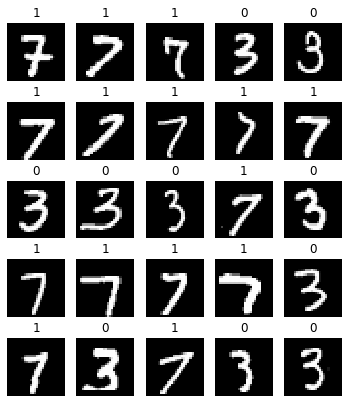

In [55]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Итерация по датасету
- x - батч с данными
- y - батч с таргетами к этим данным

In [56]:
for x, y in train_loader:
    break

### train_loader это итератор, при проходе по которому будут выдаваться батчи данных

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [57]:
x.shape

torch.Size([128, 1, 28, 28])

In [58]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Просто выпрямим нашу матрицу в один вектор
### То есть каждая фича в векторе это значение пикселя
### Для нашей игрушечной задачи этого будет достаточно

In [59]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
Это перевод торчового тензора (некоторая абстракция, о которой мы будем говорить позже на курсе) в numpy массив

In [60]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [61]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [62]:
x.shape

(128, 784)

# Таргеты
- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7

In [63]:
y

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1], dtype=int64)

# Итерация по эпохам

In [64]:
# количество эпох - полных проходов по датасету
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными
        # например, учить, но пока этого делать не будет
        # только демонстрация
        
        time.sleep(0.01)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Небольшие пояснения по numpy

In [65]:
# таким образом мы создаем матрицу 64 на 512 с рандомными значениями
x = np.random.rand(64, 512)
x

array([[0.98890737, 0.54188123, 0.55797577, ..., 0.28839094, 0.44354953,
        0.52680062],
       [0.38873113, 0.28117515, 0.28149357, ..., 0.54200081, 0.69077527,
        0.20864827],
       [0.3089334 , 0.35390889, 0.58939784, ..., 0.79528097, 0.29961472,
        0.04325038],
       ...,
       [0.77265312, 0.21789672, 0.12919427, ..., 0.78640282, 0.06016409,
        0.5713701 ],
       [0.75657139, 0.55626447, 0.28920357, ..., 0.09198694, 0.20037365,
        0.90249289],
       [0.41796165, 0.66801552, 0.92381432, ..., 0.46247922, 0.07021792,
        0.66807754]])

In [66]:
# большинство функций применяются к каждому элементу массива
# здесь мы каждый элемент массива возвели в квадрат и прибавили к получившемуся значению логарифм элемента матрицы 
x ** 2 + np.log(x)

array([[ 0.96678318, -0.31907318, -0.27210279, ..., -1.16026895,
        -0.61620961, -0.36341423],
       [-0.79375548, -1.18971805, -1.18840702, ..., -0.31872289,
         0.10722973, -1.52357128],
       [-1.07918972, -0.91346426, -0.18126405, ...,  0.40341202,
        -1.1154889 , -3.13887856],
       ...,
       [ 0.33906778, -1.47625509, -2.02974687, ...,  0.37814328,
        -2.80705991, -0.23325433],
       [ 0.29344189, -0.27708128, -1.15698576, ..., -2.37764709,
        -1.56742183,  0.71189894],
       [-0.69767365,  0.04280087,  0.77418871, ..., -0.55726662,
        -2.65122124,  0.04297657]])

In [67]:
y = np.random.rand(512, 1024)
# скалярное произведение
res = np.dot(x, y)

In [68]:
res

array([[126.57049854, 125.76332409, 123.8790918 , ..., 125.96321043,
        118.57488216, 124.47916431],
       [134.88218559, 137.74836794, 138.14409953, ..., 137.47050891,
        130.90866809, 134.5097038 ],
       [126.15280561, 129.16388652, 127.5376922 , ..., 128.47546831,
        121.19088982, 126.93682172],
       ...,
       [123.46176135, 125.68661402, 127.78561235, ..., 127.06893795,
        119.82966587, 125.6149089 ],
       [126.69381611, 128.1505216 , 130.43964985, ..., 128.01087813,
        125.47048361, 124.84409025],
       [125.25228262, 126.39397338, 128.08640904, ..., 125.83446563,
        121.66673238, 124.86517788]])

In [69]:
res.shape == (x.shape[0], y.shape[1])

True

### Производные линейного слоя
Мы знаем, что нам нужно будет по градиентам весов обновить эти веса. То есть это просто смещение наших весов на какой-то шаг. Отсюда следует, что размерность весов и градиента к ним должна совпадать. Используйте для этого скалярное произведение, траснпонирование и предыдущий градиент.  
То есть размерность какого-либо параметра должна совпадать с размерностью градиента к этому параметру. В случае с параметров b мы помним, что это смещение и по сути это добавление к нашим входным фичам фичи с единичным значением.

```python
grad_w = np.dot(x.T, grad_prev)
grad_x = np.dot(grad_prev, w.T)
grad_b = np.dot(np.ones((x.shape[0])), grad_prev)
```

Более подробный совет:  
Tip: use dimension analysis! Note that you do not need to remember the expressions for dW and dX because they are easy to re-derive based on dimensions. For instance, we know that the gradient on the weights dW must be of the same size as W after it is computed, and that it must depend on matrix multiplication of X and dD (as is the case when both X,W are single numbers and not matrices). There is always exactly one way of achieving this so that the dimensions work out. For example, X is of size [10 x 3] and dD of size [5 x 3], so if we want dW and W has shape [5 x 10], then the only way of achieving this is with np.dot(dD, X.T), as shown above.  
[Источник](https://cs231n.github.io/optimization-2/)

Полезные видео:  
- [Один](https://www.coursera.org/lecture/intro-to-deep-learning/multilayer-perceptron-mlp-yy1NV)
- [Два](https://www.coursera.org/lecture/intro-to-deep-learning/chain-rule-rK0tw)
- [Три](https://www.coursera.org/lecture/intro-to-deep-learning/backpropagation-CxUe5)
- [Четыре](https://www.coursera.org/lecture/intro-to-deep-learning/efficient-mlp-implementation-P3VH6)
- [Пять](https://www.coursera.org/lecture/intro-to-deep-learning/other-matrix-derivatives-YTunl)

# Задание

### Шаги:
1. Задайте обучаемые параметры (TIP: np.random.rand)
1. Задайте скорость обучения (подойдет 0.01, но можете попробовать другие и посмотреть что меняется), количество эпох (полных проходов по датасету)
1. Сделайте линейную трансформацию через первый слой (первый набор весов)
1. Примените какую-нибудь нелийную функцию активации (tanh, relu)
1. Сделайте линейную трансформацию через второй слой (второй набор весов)
1. Примените сигмоиду
1. Рассчитайте функцию потерь (бинарная кросс энтропия), не забудьте усреднить по батчу
1. Сохраняйте значения функции потерь в массив losses
1. Возьмите производные от функции потерь к каждому обучаемому параметру [видео про производные](https://youtu.be/tZ0yCzWfbZc)
1. Обновите веса w1, b1, w2, b2 с помощью градиентного спуска
1. Нарисуйте график функции потерь

- TIP: количество входных фичей - 784 (28 пикселей * 28 пикселей)
- TIP: в шаге 0 домножьте w1, w2 на 0.01, а b1, b2 инициализируйте нулями. Это не самая лучшая реализация, но пока лучше мы не знаем
- TIP: в backward функции потерь по предсказаниям вашей модели нужно разделить еще на количество примеров в батче (не забудьте, что усредняете лосс)
- TIP: каждый следующий градиент рассчитывайте умножая на предыдущий, то есть не нужно расчитывать по каждому слою и затем все мерджить. Нужно сразу для d_L/d_z2 считать градиент как d_L/d_y_hat умноженный на d_y_hat/d_z2, где y_hat это наши предсказания.

## Если вам трудно, сделайте сначала для одного слоя

In [189]:
learning_rate = 0.005
epochs = 3

w1 = np.random.rand(784, 100)*0.01
b1 = np.zeros(100)
w2 = np.random.rand(100, 1)*0.01
b2 = np.zeros(1)

losses = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        
        # forward
        z1 = x@w1 + b1
        z2 = z1*(z1>0) # ReLU
        z3 = z2@w2 + b2
        y_hat = 1 / (1 + np.exp(-z3))
        
        # рассчет bce
        loss = np.mean(-(y*np.log(y_hat) + (1-y)*np.log(1-y_hat)))
        losses.append(loss)
        
        # backward
        dLdy_hat = (1-y)/(1-y_hat) - y/y_hat
        dLdz3 = dLdy_hat*y_hat*(1-y_hat)
        dLdw2 = z2.T@dLdz3
        dLdb2 = np.ones(x.shape[0]).T@dLdz3
        dLdz2 = dLdz3*np.tile(w2, (1,x.shape[0])).T
        dLdz1 = dLdz2*(z1>0)
        dLdw1 = x.T@dLdz1
        dLdb1 = np.ones(x.shape[0]).T@dLdz3
        
        # gradient descent
        w1 -= learning_rate*dLdw1
        b1 -= learning_rate*dLdb1
        w2 -= learning_rate*dLdw2
        b2 -= learning_rate*dLdb2

Epoch: 1
Epoch: 2
Epoch: 3


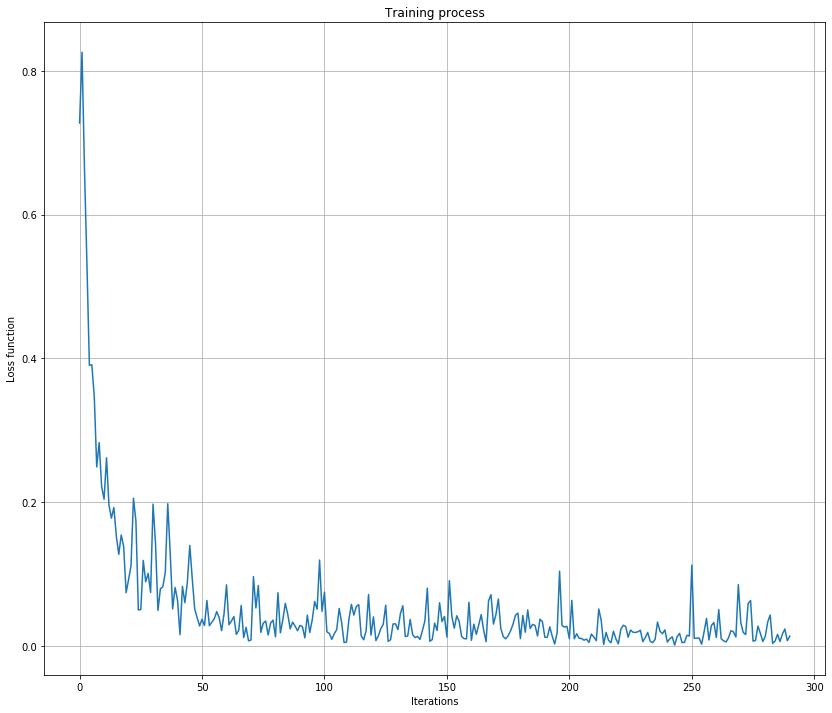

In [190]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Нужно получить значение лосса ниже 0.1 (на графике)
```np.mean(losses)``` примерно должно равняться 0.15  
Это где-то 0.9+ accuracy

In [191]:
np.mean(losses)

0.054119940637732164